In [19]:
# Importing different libraries, functions that allow performing valuations,creating dataframes, downloading information, data visualizations.
import pandas as pd
import matplotlib
import plotly.express as px
from pathlib import Path
from MCForecastTools import MCSimulation
import seaborn as sns
import hvplot.pandas
import fredapi as fa

In [7]:
# Importing data from the CSV value and saving it as a DataFrame
valuation_data_df = pd.read_csv(Path("./real_estate_info.csv"))
#First five rows of the DataFrame being displayed
valuation_data_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,252701.0,254520.0,...,711720.0,716349.0,721313.0,727207.0,732201.0,735891.0,738692.0,742776.0,747650.0,753782.0
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,237081.0,237303.0,...,876405.0,898997.0,912715.0,922531.0,925407.0,929815.0,935460.0,940493.0,949548.0,965684.0
2,39051,2,Houston,City,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,108945.0,108955.0,...,222419.0,227346.0,232692.0,236787.0,240316.0,242730.0,245503.0,248436.0,251793.0,256143.0
3,17426,3,Chicago,City,IL,IL,Chicago-Naperville-Elgin,Cook County,168395.0,168797.0,...,292262.0,294721.0,297793.0,299858.0,301899.0,304491.0,306932.0,309246.0,310564.0,312489.0
4,6915,4,San Antonio,City,TX,TX,San Antonio-New Braunfels,Bexar County,116080.0,116262.0,...,244883.0,250291.0,256005.0,259832.0,263958.0,267630.0,272340.0,277101.0,281583.0,287310.0


In [8]:
#Creating new city focused DataFrames:

#New York City/NYC-based DataFrame
nyc_df = valuation_data_df[valuation_data_df['RegionName']=="New York"]
display(nyc_df)
#Los Angeles/LA-based DataFrame
la_df = valuation_data_df[valuation_data_df['RegionName']=="Los Angeles"]
display(la_df)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,252701.0,254520.0,...,711720.0,716349.0,721313.0,727207.0,732201.0,735891.0,738692.0,742776.0,747650.0,753782.0


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,237081.0,237303.0,...,876405.0,898997.0,912715.0,922531.0,925407.0,929815.0,935460.0,940493.0,949548.0,965684.0


In [12]:
#Arranging data for NYC, cleaning information we won't be using, renaming and changing index to 'Date': 
nyc = pd.melt(nyc_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
      'State', 'Metro', 'CountyName'])
nyc['variable']= pd.to_datetime(nyc['variable'], infer_datetime_format = True)
nyc.set_index('variable', inplace=True)
# We will be looking at 10-year span of data, hence, we start at 2012-01-31
nyc = nyc.loc['2012-01-31':]
nyc = nyc.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
nyc=nyc.rename(columns={'value':'NYC Close'})
nyc.index.names = ['Date']
nyc['Change']= nyc.pct_change().dropna()
display(nyc.head(5))

,NYC Close,Change
Date,,
2012-01-31,464518.0,NaN
2012-02-29,464241.0,-0.000596
2012-03-31,462888.0,-0.002914
2012-04-30,463138.0,0.000540
2012-05-31,463022.0,-0.000250


In [14]:
#Arranging data for LA, cleaning information we won't be using, renaming and changing index to 'Date': 
la = pd.melt(la_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
la['variable']= pd.to_datetime(la['variable'], infer_datetime_format = True)
la.set_index('variable', inplace=True)
# We will be looking at 10-year span of data, hence, we start at 2012-01-31
la = la.loc['2012-01-31':]
la = la.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
la.index.names = ['Date']
la.rename(columns={'variable':'Date','value':'LA Close'}, inplace=True)
la['Change']= la['LA Close'].pct_change().dropna()
display(la.tail(10))

,LA Close,Change
Date,,
2021-06-30,876405.0,0.023749
2021-07-31,898997.0,0.025778
2021-08-31,912715.0,0.015259
2021-09-30,922531.0,0.010755
2021-10-31,925407.0,0.003118
2021-11-30,929815.0,0.004763
2021-12-31,935460.0,0.006071
2022-01-31,940493.0,0.005380
2022-02-28,949548.0,0.009628


In [39]:
# Concatinating data from DataFrames 
combined_city_df= pd.concat([nyc,la],keys=["NYC","LA"], axis="columns", sort =False).dropna()

cities_df = pd.concat([nyc,la],axis="columns", sort =False).dropna()

cities_df.drop(columns=['Change','Change'],axis=0, inplace=True)

In [40]:


#Using FREDAPI to extract the most current mortgage rate information from Federal Reserve, St. Louis

fred = fa.Fred(api_key='f381743e5771e6778ba8544e3e42f97b')

mortgages = fred.get_series('MORTGAGE30US')

mortgages



1971-04-02    7.33
1971-04-09    7.31
1971-04-16    7.31
1971-04-23    7.31
1971-04-30    7.29
              ... 
2022-04-07    4.72
2022-04-14    5.00
2022-04-21    5.11
2022-04-28    5.10
2022-05-05    5.27
Length: 2667, dtype: float64

In [41]:
#Creating DataFrame from the data extracted from API 
mortgage_rate_df = pd.DataFrame(mortgages.loc['2012-01-31':'2022-03-31'])

mortgage_rate_df.set_axis(["Interest Rate(%)"],axis=1, inplace= True)

mortgage_rate_df.index = pd.to_datetime(mortgage_rate_df.index,format ='%Y/%m/%d')


In [42]:
#Visual depiction of data side by side
mortgage_rate_df.hvplot.line(xlabel = "Timeframe", title = "Mortgage Rate in USA over the years").opts(bgcolor='green')+cities_df.hvplot(x='Date', xlabel='Timeframe', ylabel='mean real estate price', title="Comparing real estate prices between LA and NYC").opts(yformatter="%.0f", bgcolor='yellow')

:Layout
   .Curve.I     :Curve   [index]   (Interest Rate(%))
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [43]:
 nyc['nyc close'].corr(mortgages_df['changes'])

0.23407854440264503

In [42]:
nyc['change'].corr(mortgages_df['changes'])

0.36420028875874955

In [47]:
la['la close'].corr(mortgages_df['changes'])

0.39447040133898353

In [46]:
la['change'].corr(mortgages_df['changes'])

0.304512393704306

In [50]:
la['change'].corr(nyc['change'])

0.23436896558002634

In [34]:
fig = px.imshow(monte_combo['nyc change','la change'])

NameError: name 'px' is not defined

:Layout
   .Curve.I     :Curve   [index]   (Interest Rate(%))
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [40]:
mortgages_df['changes']= mortgages_df['Interest Rate(%)'].pct_change().dropna()

In [52]:
visual = pd.concat([mortgages_df,cities_df)

In [54]:
visual

,Interest Rate(%),nyc close,la close
2012-02-02,3.87,NaN,NaN
2012-02-09,3.87,NaN,NaN
2012-02-16,3.87,NaN,NaN
2012-02-23,3.95,NaN,NaN
2012-03-01,3.90,NaN,NaN
...,...,...,...
2021-11-30,NaN,735891.0,929815.0
2021-12-31,NaN,738692.0,935460.0
2022-01-31,NaN,742776.0,940493.0
2022-02-28,NaN,747650.0,949548.0


In [55]:
correlation = visual.corr()

,Interest Rate(%),nyc close,la close
Interest Rate(%),1.0,NaN,NaN
nyc close,NaN,1.000000,0.962608
la close,NaN,0.962608,1.000000


<AxesSubplot:>

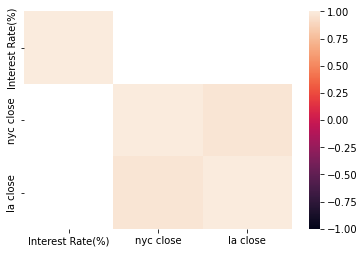

In [61]:
sns.heatmap(correlation,vmin=-1,vmax=1)

In [46]:
covariances = mortgage_rate_df.cov(nyc['Change'])
covariances

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [17]:
nyc1 = pd.melt(nyc_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])

nyc1['variable']= pd.to_datetime(nyc1['variable'], infer_datetime_format = True)

nyc1.set_index('variable', inplace=True)

nyc1 = nyc1.loc['2012-01-31':]
nyc1 = nyc1.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
nyc1=nyc1.rename(columns={'value':'close'})
nyc1.index.names = ['Date']

nyc1

,close
Date,
2012-01-31,464518.0
2012-02-29,464241.0
2012-03-31,462888.0
2012-04-30,463138.0
2012-05-31,463022.0
...,...
2021-11-30,735891.0
2021-12-31,738692.0
2022-01-31,742776.0


In [18]:
la1 = pd.melt(la_df, id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])

la1['variable']= pd.to_datetime(la1['variable'], infer_datetime_format = True)

la1.set_index('variable', inplace=True)

la1 = la1.loc['2012-01-31':]
la1 = la1.drop(columns= ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName'])
la1.index.names = ['Date']
la1.rename(columns={'variable':'Date','value':'close'}, inplace=True)
la1

,close
Date,
2012-01-31,404944.0
2012-02-29,404864.0
2012-03-31,404603.0
2012-04-30,405428.0
2012-05-31,406655.0
...,...
2021-11-30,929815.0
2021-12-31,935460.0
2022-01-31,940493.0


In [38]:


montecarlo_df = pd.concat([nyc1,la1],keys=["NYC","LA"], axis="columns", sort =False).dropna()

monte_combo

,NYC,LA
,close,close
Date,,
2012-01-31,464518.0,404944.0
2012-02-29,464241.0,404864.0
2012-03-31,462888.0,404603.0
2012-04-30,463138.0,405428.0
2012-05-31,463022.0,406655.0
...,...,...
2021-11-30,735891.0,929815.0
2021-12-31,738692.0,935460.0


In [ ]:

#Montecarlo simulation 
thirty_year_simulation = MCSimulation(
    portfolio_data=monte_combo,
    weights=[100.0,0],
    num_simulation=50,
    num_trading_days=10*1,
)

In [109]:
thirty_year_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.850496,0.926873,1.305536,1.096900,1.337753,1.109031,1.041058,1.844450,1.016733,1.581512,...,1.345450,1.488132,1.548999,1.398898,1.211704,1.393056,1.722563,1.534753,1.431452,1.884429
2,2.138195,0.779264,2.179231,1.540921,2.268209,1.854283,1.695843,2.448036,1.578364,2.859275,...,1.863757,2.694451,2.622676,1.718319,2.021295,1.989946,2.101324,2.652381,2.110497,2.757466
3,2.854763,1.271106,3.134622,2.155650,2.452838,3.107801,2.517960,3.911093,2.210006,4.243889,...,2.357478,3.113675,4.124785,2.217754,2.328998,3.220512,3.289434,3.283688,2.592918,2.885941
4,3.877734,1.747895,5.702398,3.148733,4.095271,4.612136,3.823101,6.558398,3.083634,6.896301,...,2.980745,3.540746,6.937183,3.073490,3.680733,4.979047,4.432039,4.394502,3.653257,4.320272
5,4.571567,3.676665,8.406871,2.772325,6.303852,4.163361,5.314207,11.572240,3.532011,9.160114,...,3.378056,3.147077,7.172980,3.832404,3.613789,8.652797,5.228439,7.653069,5.636475,6.927932
6,7.093408,4.481508,9.688576,3.963163,11.322173,4.312505,4.893955,16.659716,3.398612,17.135473,...,5.051100,3.655781,8.703592,5.478546,4.893571,9.725200,5.906327,8.892743,9.214092,9.961153
7,10.014562,4.298888,12.412378,4.027267,15.768341,6.285366,6.394993,25.518205,5.768961,20.146626,...,3.773757,4.761044,12.670262,9.085989,5.658954,14.054451,13.769272,12.599179,10.607232,13.169280
8,14.934317,6.114537,11.360593,6.453835,16.279202,8.441696,10.360238,34.508208,5.410760,21.080428,...,4.140252,7.996993,12.876916,12.196147,3.804673,9.827295,15.833780,10.452369,14.505221,21.189163
9,19.343307,5.323181,18.298002,8.960987,22.615429,15.524478,14.176772,65.685925,7.465163,37.283453,...,6.766215,10.708527,15.330110,18.192090,4.232562,11.951599,16.215124,17.399594,19.855528,29.381042


<AxesSubplot:title={'center':'50 Simulations of Cumulative Portfolio Return Trajectories Over the Next 360 Trading Days.'}>

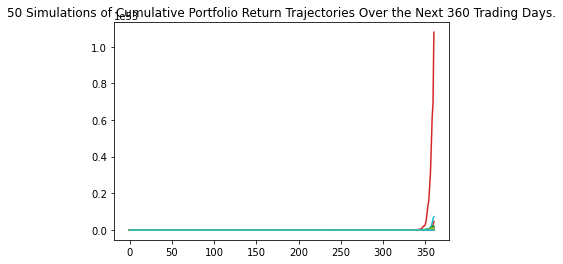

In [103]:
thirty_year_simulation.plot_simulation() 

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 50 Simulations'}, ylabel='Frequency'>

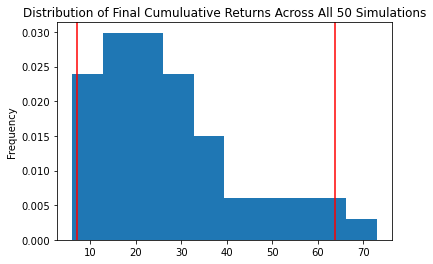

In [110]:
thirty_year_simulation.plot_distribution() 

In [111]:
summary_stats = thirty_year_simulation.summarize_cumulative_return()
summary_stats

count           50.000000
mean            26.594460
std             16.067155
min              5.986207
25%             14.502127
50%             22.996066
75%             35.849013
max             72.874052
95% CI Lower     7.094923
95% CI Upper    63.734455
Name: 10, dtype: float64

In [112]:
begin_value = float(500000)
ci_lower_one_cumulative_return = round(summary_stats[8]*begin_value,2)
ci_upper_one_cumulative_return = round(summary_stats[9]*begin_value,2)
mean_return = round(summary_stats[1]*begin_value,2) 

In [113]:
print(f"{ci_lower_one_cumulative_return:.02f}")
display(ci_upper_one_cumulative_return)
display(mean_return)

3547461.49


31867227.67

13297230.13

In [114]:
thirty_year_simulation_la = MCSimulation(
    portfolio_data=monte_combo,
    weights=[0.0,100.0],
    num_simulation=50,
    num_trading_days=10*1,
)

In [115]:
thirty_year_simulation_la.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.282397,1.431242,0.899369,1.993831,1.517337,1.736807,1.181952,2.220714,1.041853,1.830799,...,1.930335,2.184330,1.210745,0.724976,2.322980,2.042454,1.288140,1.822560,1.914726,2.328360
2,1.452320,2.719216,1.397911,2.461238,2.362717,3.365056,3.197017,5.768395,0.756868,3.569080,...,4.969847,5.005862,0.564591,1.212531,0.193118,3.453682,1.758381,2.543719,3.118067,3.925634
3,2.450869,4.225993,0.736604,5.231154,4.767532,7.712095,3.085413,15.748075,1.500454,6.492722,...,9.244316,6.742869,1.367312,2.784669,0.280656,4.198551,2.815604,2.321184,8.975801,5.373243
4,5.456450,9.082349,2.021741,9.702694,9.276842,9.509800,2.631088,33.686448,3.044807,14.243939,...,16.174054,8.022998,1.655305,4.871194,0.595932,6.706645,4.861750,6.698302,15.217128,9.080726
5,12.824697,26.298563,4.744432,16.275470,28.112701,21.037314,5.043414,56.266435,4.553892,28.942205,...,28.434065,11.614522,2.282375,12.979062,1.581186,10.939103,4.609909,13.086504,20.168927,12.762313
6,18.247062,64.620617,8.787229,24.947409,43.970090,41.961876,8.793260,38.382761,11.994905,49.011124,...,60.242841,6.586585,4.885724,18.156911,2.325540,14.348694,8.995799,16.177594,61.127151,8.523874
7,25.435281,150.627632,17.841698,42.057383,52.988228,47.667962,9.894578,75.601218,25.061614,43.792683,...,126.840428,7.252586,9.845364,39.493701,1.976191,29.521853,16.375052,27.894260,146.385600,6.980432
8,59.501050,162.168340,17.329890,133.891859,102.935753,46.304109,28.062895,139.190456,47.071453,113.230975,...,314.484137,14.714586,13.486567,53.912872,3.438679,40.864338,22.744616,40.488093,226.845413,15.319278
9,98.866999,193.666325,21.792170,23.310225,93.349141,90.816779,77.291518,367.729553,90.270111,254.258948,...,616.049153,25.171740,19.843805,92.769617,5.728815,38.050359,49.102368,46.711923,293.146761,23.386446


<AxesSubplot:title={'center':'50 Simulations of Cumulative Portfolio Return Trajectories Over the Next 10 Trading Days.'}>

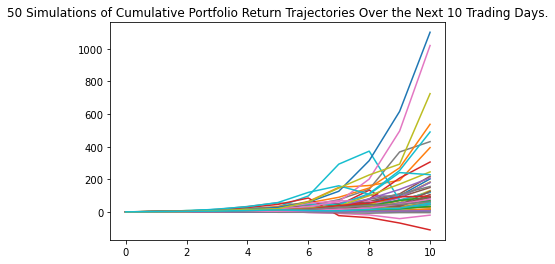

In [118]:
thirty_year_simulation_la.plot_simulation() 

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 50 Simulations'}, ylabel='Frequency'>

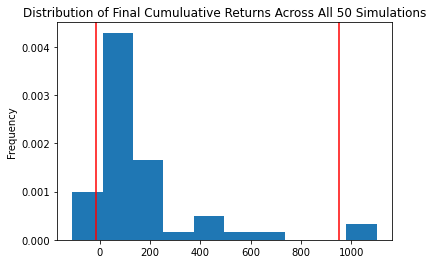

In [120]:
thirty_year_simulation_la.plot_distribution()

In [122]:
summary_stats_la = thirty_year_simulation_la.summarize_cumulative_return()
summary_stats_la

count             50.000000
mean             174.517694
std              238.344359
min             -109.667948
25%               48.449600
50%               92.678193
75%              198.010898
max             1100.578557
95% CI Lower     -15.796075
95% CI Upper     953.133987
Name: 10, dtype: float64

In [123]:
begin_value = float(500000)
ci_lower_one_cumulative_return_la = round(summary_stats_la[8]*begin_value,2)
ci_upper_one_cumulative_return_la = round(summary_stats_la[9]*begin_value,2)
mean_return_la = round(summary_stats_la[1]*begin_value,2)

In [124]:
print(f"{ci_lower_one_cumulative_return_la:.02f}")
display(ci_upper_one_cumulative_return_la)
display(mean_return_la)

-7898037.43


476566993.66

87258846.9